<a href="https://colab.research.google.com/gist/PaliC/084fb5b4ee9ce904bc7791ad4aa51e75/benchmarking_guide.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# A Practical Guide to GPU Benchmarking

> **Note on outputs:** The outputs in this notebook were generated on an **NVIDIA H200 GPU** (90MB L2 cache, 4.8 TB/s memory bandwidth). Your results may vary depending on your hardware. The H200's large cache means cache effects are less dramatic than on older GPUs like A100 (40MB L2) or consumer cards.

## TL;DR — How to Benchmark Correctly

Benchmarking on GPUs requires a strict protocol to avoid measuring Python overhead or caching artifacts. To get reliable numbers, you must:

1.  **Warmup:** Run the kernel ~10-50 times first to settle compilation and memory allocators.
2.  **Sample Extensively:** Don't trust one run. Collect 100+ samples to build a statistical distribution.
3.  **Flush the L2 Cache:** Between *every* sample, flush the cache to force a cold cache state (simulating real-world inference).
4.  **Use Device Timers:** Use `torch.cuda.Event` instead of `time.time()` to measure execution on the GPU, not the CPU driver.
5.  **Aggregate Robustly:** Aggregate over many samples to filter out jitter/outliers.
6.  **Wait for sidestreams to finish:** Ensure no side-streams are running or wait for all of them to finish before reporting a time.

*Pro-Tip:* **KernelBench's timing module** (`src/timing.py`) implements all these best practices. Use `get_timing_function("cuda_event")` for trusted code or `get_timing_function("host_time")` for evaluating untrusted/agent-generated code.

-----

If are using an LLM agent to write GPU kernels (and evaluating against something like say [Kernel Bench](https://github.com/ScalingIntelligence/KernelBench)), or just trying to optimize a custom GPU kernel, you are eventually going to ask: **"How fast is this thing?"**

This notebook is heavily inspired by [this great guide](https://www.youtube.com/watch?v=1i7dxoAfKOU) from the **GPU MODE** community and the practical "footguns" (traps) encountered while building benchmarking harnesses for LLM-generated code. Our goal here is simplicity and keeping things Pythonic—for more advanced techniques, see the footnotes.

We won't just list best practices. Instead, we are going to build a benchmarking harness from scratch, make every common mistake, debug why the numbers are wrong, and iterate our way to a robust solution. So let's start things out by doing the most naive thing by using `time.time()`!

In [1]:
# @title Environment Setup
# Ensure we have the necessary libraries and a GPU available
# !pip install -q triton matplotlib numpy torch
# !pip install -e ..  # Install KernelBench locally for timing utilities

import sys
import os
sys.path.insert(0, '..')  # Add parent directory to path for imports

# For multi-GPU systems, set CUDA_VISIBLE_DEVICES=X before running to select a specific GPU
os.environ["CUDA_VISIBLE_DEVICES"] = "5"

import torch
import time
import numpy as np
import matplotlib.pyplot as plt
import triton

# Import KernelBench's timing module
from src import timing
from src.timing import clear_l2_cache, get_timing_stats, get_timing_function

if not torch.cuda.is_available():
    raise RuntimeError("This notebook requires a GPU. Please enable GPU in your runtime settings.")

# Device configuration
# The selected GPU will appear as cuda:0

DEVICE = f"cuda:0"
print(f"Using GPU: {torch.cuda.get_device_name(DEVICE)}")

/home/simon/palic/KernelBench/.venv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Using GPU: NVIDIA H200


## The Journey: Benchmarking a Matrix Multiplication

Let's define a simple workload to test. We want to measure the performance of a standard Matrix Multiplication.

In [2]:
# A standard size for testing
N = 8192

def get_data(n=N, device=DEVICE):
    """Generate random float32 matrices for benchmarking."""
    return torch.randn(n, n, device=device), torch.randn(n, n, device=device)

def simple_mm(a, b):
    """Our kernel under test: standard matrix multiplication."""
    return torch.matmul(a, b)

# Let's verify it runs
a, b = get_data()
res = simple_mm(a, b)
print(f"Output shape: {res.shape}")
print("Op ran successfully")

Output shape: torch.Size([8192, 8192])
Op ran successfully


### Attempt 1: The Naive Timer

The most intuitive way to time code in Python is using `time.time()`. Let's try that first.

In [3]:
def benchmark_naive(func, *args):
    """WRONG: Measures kernel launch time, not execution time."""
    start = time.time()
    func(*args)
    end = time.time()
    return (end - start) * 1000  # to ms

t = benchmark_naive(simple_mm, a, b)
print(f"Naive time: {t:.4f} ms")

Naive time: 0.6356 ms


**The Problem:**
Wait, less than 1ms? That seems impossibly fast for a 8192² matrix multiplication involving over 1 trillion floating-point operations.[¹](#footnote-1)

**What happened?**
GPUs are **asynchronous**. When you call `torch.matmul`, the CPU doesn't actually do the math. It simply queues a "launch kernel" command to the GPU and moves on immediately. Our timer didn't measure the matrix multiplication; it measured how long it took Python to place an order in the queue.

To fix this, we need to:
1. **Synchronize** - Force the CPU to wait for the GPU with `torch.cuda.synchronize()`
2. **Use CUDA Events** - Record timestamps directly on the GPU to avoid CPU overhead

Let's compare these approaches to see the difference.

---

<a id="footnote-1"></a>
¹ **Why impossible?** The [H200](https://www.nvidia.com/en-us/data-center/h200/) peaks at 989 TFLOPS for TF32 Tensor Cores. At that rate: 1.1 TFLOP ÷ 989 TFLOP/s = **1.11ms minimum**. Anything under 1ms is physically impossible.

### Attempt 2: Synchronizing the Device

To fix this, we need to force the CPU to wait until the GPU has finished its work before we stop the clock. We do this with `torch.cuda.synchronize()`.

In [4]:
def benchmark_sync(func, *args):
    """Better: Actually waits for GPU to finish."""
    torch.cuda.synchronize()  # Wait for previous work to finish
    start = time.time()
    func(*args)
    torch.cuda.synchronize()  # Wait for THIS work to finish
    end = time.time()
    return (end - start) * 1000

t = benchmark_sync(simple_mm, a, b)
print(f"Sync time: {t:.4f} ms")

Sync time: 21.5368 ms


### Attempt 3: Removing CPU Overhead (CUDA Events)

To get a precise measurement, we need to bypass the CPU clock entirely. We can ask the GPU driver to record timestamps directly on the device using `torch.cuda.Event`.

In [5]:
def benchmark_events(func, *args):
    """Better: Uses GPU timestamps, avoiding CPU overhead."""
    start_event = torch.cuda.Event(enable_timing=True)
    end_event = torch.cuda.Event(enable_timing=True)

    torch.cuda.synchronize(device=DEVICE)
    start_event.record()
    func(*args)
    end_event.record()
    torch.cuda.synchronize(device=DEVICE)

    return start_event.elapsed_time(end_event)  # Returns ms directly

# Run it a few times
for i in range(3):
    print(f"Run {i}: {benchmark_events(simple_mm, a, b):.4f} ms")

Run 0: 21.7344 ms
Run 1: 21.4754 ms
Run 2: 21.4987 ms


### Attempt 4: Handling the "Cold Start"

Notice Run 0 is noticably slower than the rest. The first time you run a PyTorch function (and similarly launching a cuda kernel), the framework does a lot of heavy lifting which could include: allocating memory, initializing cuBLAS/cuDNN workspaces, lazy kernel loading, and compiling kernels (especially if using `torch.compile` or Triton). This "Cold Start" penalty is a one-time cost that shouldn't be included in your performance metrics.

**The Fix:**
We need to perform **Warmup Runs**—running the kernel a few times to settle the system state before we start measuring.

In [6]:
def benchmark_warmup(func, *args, warmup_iters=30, benchmark_iters=3):
    """Better: Includes warmup to avoid cold-start penalty."""
    # Warmup phase
    for _ in range(warmup_iters):
        func(*args)
    torch.cuda.synchronize(device=DEVICE)

    # Measurement phase
    measurements = []
    for _ in range(benchmark_iters):
        measurements.append(benchmark_events(func, *args))
    torch.cuda.synchronize(device=DEVICE)
    return measurements

# print(f"Warmed up time: {benchmark_warmup(simple_mm, a, b):.4f} ms")

for i, measurement in enumerate(benchmark_warmup(simple_mm, a, b)):
    print(f"Run {i}: {measurement:.4f} ms")

Run 0: 21.6478 ms
Run 1: 21.4837 ms
Run 2: 21.4852 ms


### Attempt 5: The Single Sample Fallacy (Variance)

Relying on a single sample after warmup is bad science. Operating systems are noisy; background processes interrupt the CPU, and GPU clocks fluctuate thermally. A single measurement is anecdotal, not statistical.

#### Visualizing the Jitter

Let's run the benchmark 100 times and plot every single run. You will clearly see the "Cold Start" spike and the noise floor of the OS.

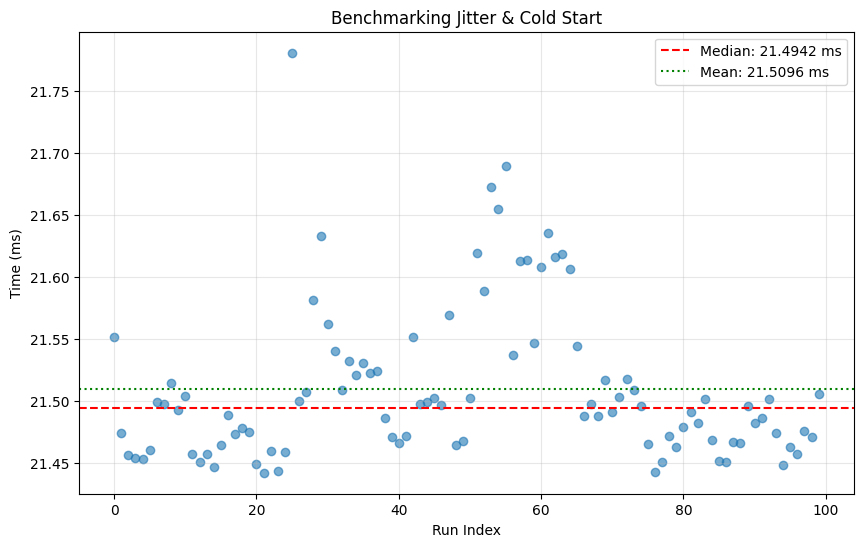

Mean:   21.5096 ms
Median: 21.4942 ms
Std:    0.0625 ms
Min:    21.4420 ms
Max:    21.7808 ms


In [7]:
# Collect 100 samples
timings = []
for i in range(100):
    timings.append(benchmark_events(simple_mm, a, b))

plt.figure(figsize=(10, 6))
plt.scatter(range(100), timings, alpha=0.6)
plt.axhline(y=np.median(timings), color='r', linestyle='--', label=f'Median: {np.median(timings):.4f} ms')
plt.axhline(y=np.mean(timings), color='g', linestyle=':', label=f'Mean: {np.mean(timings):.4f} ms')
plt.title("Benchmarking Jitter & Cold Start")
plt.ylabel("Time (ms)")
plt.xlabel("Run Index")
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

print(f"Mean:   {np.mean(timings):.4f} ms")
print(f"Median: {np.median(timings):.4f} ms")
print(f"Std:    {np.std(timings):.4f} ms")
print(f"Min:    {np.min(timings):.4f} ms")
print(f"Max:    {np.max(timings):.4f} ms")

You will see a massive dot at $x=0$ (the cold start), followed by a cloud of dots hovering around the "true" time. This visualizes why we need **Warmup** (to skip $x=0$) and **Statistics** (to handle the cloud).

Notice how the **Mean** is pulled upward by the outliers, while the **Median** represents the typical case more accurately. When possible, we should use the **Median** as our final metric.

### Attempt 6: The "Robust" Harness (Flushing Cache)

Modern GPUs have large L2 caches (40MB-192MB depending on architecture). If your data fits in the cache, subsequent iterations in your loop will skip the slow VRAM access, artificially inflating your speed. In production, data usually streams in from VRAM, so this "hot cache" benchmark is misleading.

**The Fix:**
We must **flush the L2 cache** between *every single sample*. We do this by writing to a tensor large enough to completely evict the cache contents. KernelBench uses a ~256MB tensor to safely cover all GPU architectures, including the largest caches (e.g., Blackwell at ~192MB).

In [8]:
# KernelBench provides utilities to flush the L2 cache
# This is important for cold cache measurements that simulate real-world inference

def clear_l2_cache(device=DEVICE):
    """Flush L2 cache by writing to a large tensor.
    
    L2 cache sizes vary by GPU, so we use 256MB to cover all cases.
    """
    dummy = torch.empty((32, 1024, 1024), dtype=torch.int64, device=device)  # 256MB
    dummy.fill_(1901)  # Force write to thrash cache
    del dummy

# KernelBench also provides clear_l2_cache_triton() for cross-platform support
# (works on both NVIDIA and AMD GPUs via Triton's device abstraction)
from src.timing import clear_l2_cache_triton

#### Why does flushing the cache matter?

Let's see the cache effect in action. We'll benchmark the same operation twice:
1. **Without** cache flushing between runs (data stays in L2 cache)
2. **With** cache flushing between runs (data must be fetched from VRAM each time)

In [9]:
# Demonstrate why L2 cache flushing matters
# Use a smaller matrix so the effect is visible (data fits in cache)
N_SMALL = 512
a_small, b_small = get_data(N_SMALL)

NUM_SAMPLES = 20

# do warmup runs
for _ in range(NUM_SAMPLES):
    clear_l2_cache(device=DEVICE)
    benchmark_events(simple_mm, a_small, b_small)
    torch.cuda.synchronize(device=DEVICE)

# Benchmark WITHOUT cache flushing (warm cache - unrealistic)
print("Without cache flushing (warm cache):")
times_warm = []
for i in range(NUM_SAMPLES):
    t = benchmark_events(simple_mm, a_small, b_small)
    times_warm.append(t)

# Benchmark WITH cache flushing (cold cache - realistic)
print("\nWith cache flushing (cold cache):")
times_cold = []
for i in range(NUM_SAMPLES):
    clear_l2_cache(device=DEVICE)  # Flush cache before each measurement
    t = benchmark_events(simple_mm, a_small, b_small)
    times_cold.append(t)

print(f"\nWarm cache median: {np.median(times_warm):.4f} ms")
print(f"Cold cache median: {np.median(times_cold):.4f} ms")
print(f"Difference: {np.median(times_cold) - np.median(times_warm):.4f} ms ({(np.median(times_cold)/np.median(times_warm) - 1)*100:.1f}% slower with cold cache)")
print("\nWithout cache flushing, you measure artificially fast times!")

Without cache flushing (warm cache):

With cache flushing (cold cache):

Warm cache median: 0.0280 ms
Cold cache median: 0.0318 ms
Difference: 0.0038 ms (13.7% slower with cold cache)

Without cache flushing, you measure artificially fast times!


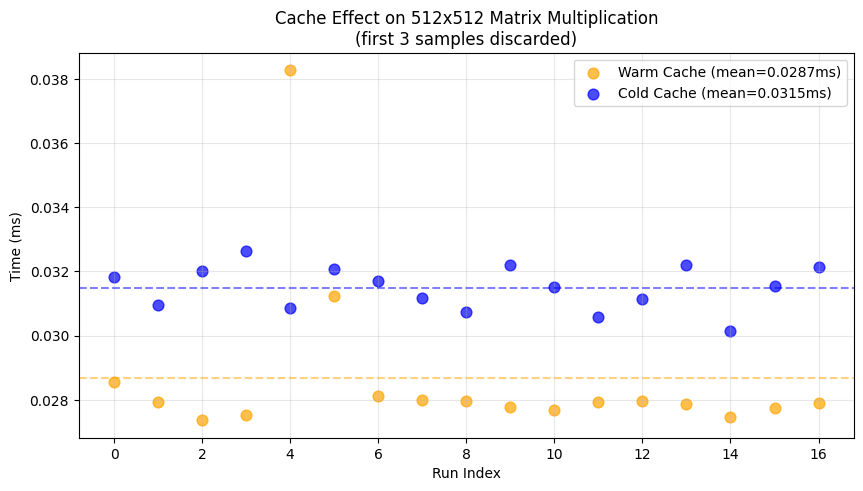

In [10]:
# Visualize the cache effect
# Discard first few samples to remove initialization noise
discard = 3
times_warm_clean = times_warm[discard:]
times_cold_clean = times_cold[discard:]

plt.figure(figsize=(10, 5))
plt.scatter(range(len(times_warm_clean)), times_warm_clean, alpha=0.7, label=f'Warm Cache (mean={np.mean(times_warm_clean):.4f}ms)', color='orange', s=60)
plt.scatter(range(len(times_cold_clean)), times_cold_clean, alpha=0.7, label=f'Cold Cache (mean={np.mean(times_cold_clean):.4f}ms)', color='blue', s=60)
plt.axhline(y=np.mean(times_warm_clean), color='orange', linestyle='--', alpha=0.5)
plt.axhline(y=np.mean(times_cold_clean), color='blue', linestyle='--', alpha=0.5)
plt.xlabel('Run Index')
plt.ylabel('Time (ms)')
plt.title(f'Cache Effect on {N_SMALL}x{N_SMALL} Matrix Multiplication\n(first {discard} samples discarded)')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

### Putting it all together

We have now discovered that a robust benchmark requires:

1.  Device Synchronization
2.  CUDA Events (to avoid CPU overhead)
3.  Warmup Runs (to avoid initialization costs)
4.  Multiple Samples (to handle variance)
5.  Cache Flushing (to simulate VRAM access)
6.  Median/Mean Aggregation (to ignore jitter)

Writing this boilerplate every time is painful. We've packaged all these lessons into **KernelBench's timing module**, which provides multiple timing methods for different use cases. There are also other robust implementations available, such as Triton's `do_bench` [function](https://triton-lang.org/main/python-api/generated/triton.testing.do_bench.html).

The default `cuda_event` method in KernelBench implements all of the above automatically, plus an additional insight: **`discard_first`** - discarding the first few trials after warmup, which often still have some initialization overhead.

In [11]:
# Get the timing function - cuda_event is the default for trusted code
timing_fn = get_timing_function("cuda_event")

def final_benchmark(func, *args, num_trials=100):
    """Production-ready benchmarking using KernelBench's timing module."""
    elapsed_times = timing_fn(
        kernel_fn=func,
        args=list(args),
        num_warmup=10,
        num_trials=num_trials,
        discard_first=1,  # Discard first trial for consistency
        verbose=False,
        device=DEVICE
    )
    stats = get_timing_stats(elapsed_times, device=DEVICE)
    return stats["mean"]

t = final_benchmark(simple_mm, a, b)
print(f"KernelBench cuda_event time: {t:.4f} ms")

[Profiling] Using timing method: cuda_event
[Profiling] Using device: cuda:0 NVIDIA H200, warm up 10, trials 100
KernelBench cuda_event time: 21.5000 ms


*Note: KernelBench also wraps Triton's `do_bench` if you prefer adaptive trial counts. See the timing methods comparison below for details.*

---

## KernelBench's Timing Methods Explained

Now that we've built up a robust benchmarking harness from first principles, let's explore KernelBench's timing module in depth. We'll examine:
- **All 4 timing methods** and when to use each
- **The `discard_first` parameter** and why it improves measurement consistency
- **How `host_time` detects side-stream exploits** in untrusted code

KernelBench's timing module provides **4 timing methods**, each designed for different use cases:

| Method | Use Case | Catches Side-Streams | Cold Cache | Trial Control |
|--------|----------|---------------------|------------|---------------|
| `cuda_event` | Default, trusted code | No | Yes | Explicit |
| `host_time` | Untrusted code, agent evals | **Yes** | Yes | Explicit |
| `do_bench` | Triton-style / robust adaptive | No | Yes | Adaptive (time-budget) |
| `do_bench_impl` | do_bench implementation for inference and trial control | No | Yes | Explicit |

### Method Details

**`cuda_event`** (Default)
- Uses `torch.cuda.Event` for GPU-side timing
- Most accurate for pure kernel time measurement
- Clears L2 cache before each trial for cold-cache performance
- Use for trusted code where you control the kernel implementation

**`host_time`** (For Untrusted Code)
- Uses **both** `time.perf_counter()` (host) and `torch.cuda.Event` (device) timing
- Compares the two: if they differ significantly, the CUDA event time is likely invalid (e.g., side-stream exploit)
- Falls back to host time when discrepancy detected, ensuring correctness
- Waits for ALL streams via `torch.cuda.synchronize()`
- **Essential for evaluating untrusted/agent-generated code**

**`do_bench`** (Triton's Adaptive Benchmarking)
- Wraps Triton's `triton.testing.do_bench`
- Uses fixed time budgets: 25ms warmup, 100ms for repetitions
- Trial count is automatic based on kernel runtime
- **Note:** `num_warmup`, `num_trials`, `discard_first` parameters are ignored

**`do_bench_impl`** (Transparent Implementation)
- Custom implementation mirroring Triton's do_bench
- Gives you explicit control over `num_warmup` and `num_trials`
- Useful when you need do_bench's approach but with specific trial counts

### Key Parameters

All timing functions share a common interface:

```python
timing_fn(
    kernel_fn,           # Function to time
    args,                # List of arguments to pass
    num_warmup=3,        # Warmup iterations before timing
    num_trials=10,       # Number of timing samples to collect
    discard_first=1,     # Drop first N trials after warmup
    device="cuda:0",     # Explicit GPU device selection
    verbose=True         # Print per-trial timing info
) -> list[float]         # Returns list of elapsed times in ms
```

### Why `discard_first`?

Even after warmup, the first few timing trials can be affected by:
- PyTorch's lazy tensor allocation finalizing
- cuDNN autotuning (still settling optimal algorithms)
- Driver state initialization
- First access to data structures

Setting `discard_first=1` (the default) improves measurement consistency. Let's visualize this effect:

# Comparing All 4 Timing Methods

Let's see how the different timing methods compare on the same kernel. Each method has trade-offs between precision, features, and overhead.

Comparing all KernelBench timing methods on 4096x4096 matmul:

Testing cuda_event...
[Profiling] Using timing method: cuda_event
[Profiling] Using device: cuda:0 NVIDIA H200, warm up 10, trials 50
  cuda_event: 21.5000 ms (std=0.0572)

Testing host_time...
[Profiling] Using timing method: host_time
[Profiling] Using device: cuda:0 NVIDIA H200, warm up 10, trials 50
  host_time: 21.5000 ms (std=0.0427)

Testing do_bench...
[Profiling] Using timing method: do_bench
  do_bench: 21.4000 ms (std=0.0030)

Testing do_bench_impl...
[Profiling] Using timing method: do_bench_impl
  do_bench_impl: 21.4000 ms (std=0.0315)


/tmp/ipykernel_710987/1660294801.py:64: UserWarning: Attempting to set identical low and high ylims makes transformation singular; automatically expanding.
  axes[1].set_ylim(min_val - margin, max_val + margin)


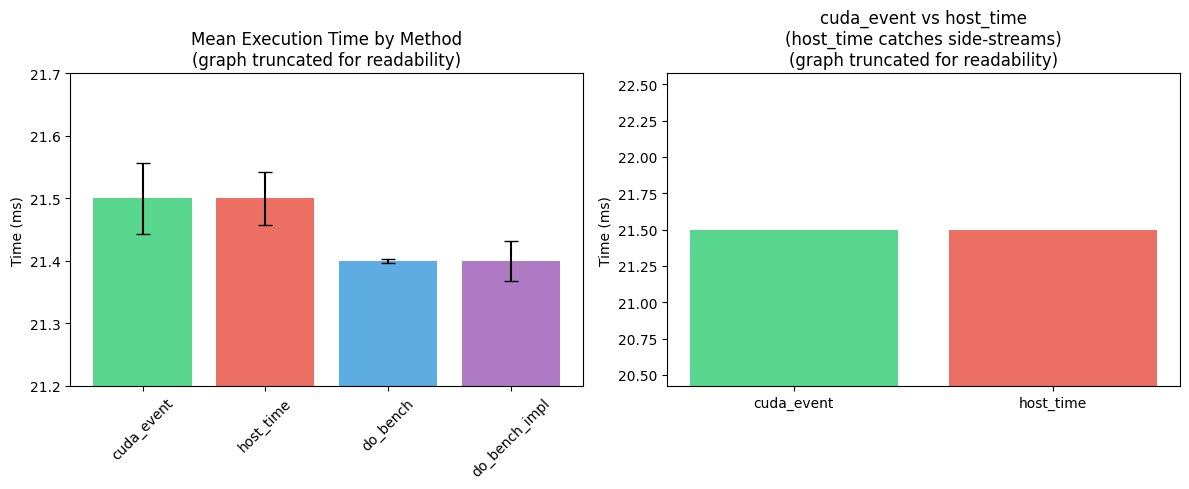


Key insight: host_time is slightly slower due to CPU overhead,
but it catches ALL work on ALL streams - essential for untrusted code!


In [12]:
# Compare all KernelBench timing methods on 4096x4096 matmul
print("Comparing all KernelBench timing methods on 4096x4096 matmul:")
print("=" * 70)

methods = ["cuda_event", "host_time", "do_bench", "do_bench_impl"]
results = {}

for method in methods:
    print(f"\nTesting {method}...")
    try:
        method_fn = get_timing_function(method)
        times = method_fn(
            simple_mm, 
            [a, b], 
            num_warmup=10, 
            num_trials=50, 
            verbose=False,
            device=DEVICE
        )
        results[method] = get_timing_stats(times, device=DEVICE)
        print(f"  {method}: {results[method]['mean']:.4f} ms (std={results[method]['std']:.4f})")
    except Exception as e:
        print(f"  {method}: Skipped due to {type(e).__name__} (Triton version compatibility)")
        # Remove from list if it failed
        methods = [m for m in methods if m in results]

# Only plot if we have results
if results:
    # Visualize the comparison
    fig, axes = plt.subplots(1, 2, figsize=(12, 5))

    # Bar chart of mean times
    available_methods = [m for m in methods if m in results]
    means = [results[m]['mean'] for m in available_methods]
    stds = [results[m]['std'] for m in available_methods]
    colors = ['#2ecc71', '#e74c3c', '#3498db', '#9b59b6'][:len(available_methods)]

    axes[0].bar(available_methods, means, yerr=stds, capsize=5, color=colors, alpha=0.8)
    axes[0].set_ylabel('Time (ms)')
    axes[0].set_title('Mean Execution Time by Method\n(graph truncated for readability)')
    axes[0].tick_params(axis='x', rotation=45)

    # Truncate y-axis to make differences easier to see
    min_mean = min(means)
    max_mean = max(means)
    margin = (max_mean - min_mean) * 2
    axes[0].set_ylim(min_mean - margin, max_mean + margin)

    # Highlight cuda_event vs host_time with truncated y-axis for readability
    if 'cuda_event' in results and 'host_time' in results:
        cuda_mean = results['cuda_event']['mean']
        host_mean = results['host_time']['mean']
        
        axes[1].bar(['cuda_event', 'host_time'], 
                    [cuda_mean, host_mean], 
                    color=['#2ecc71', '#e74c3c'], alpha=0.8)
        axes[1].set_ylabel('Time (ms)')
        axes[1].set_title('cuda_event vs host_time\n(host_time catches side-streams)\n(graph truncated for readability)')
        
        # Truncate y-axis to make the difference easier to see
        min_val = min(cuda_mean, host_mean)
        max_val = max(cuda_mean, host_mean)
        margin = (max_val - min_val) * 2  # Add margin around the data
        axes[1].set_ylim(min_val - margin, max_val + margin)
    else:
        axes[1].text(0.5, 0.5, 'Comparison unavailable', ha='center', va='center')
        axes[1].set_axis_off()

    plt.tight_layout()
    plt.show()

print("\nKey insight: host_time is slightly slower due to CPU overhead,")
print("but it catches ALL work on ALL streams - essential for untrusted code!")

### The `discard_first` Effect

Even after warmup, the first timing trial can be affected by lazy initialization. Let's see this in action.

Demonstrating the discard_first effect:
[Profiling] Using timing method: cuda_event
[Profiling] Using device: cuda:0 NVIDIA H200, warm up 3, trials 15

First trial:         0.3660 ms
Mean of all trials:  0.3455 ms
Mean without first:  0.3440 ms
First trial overhead: 6.4%


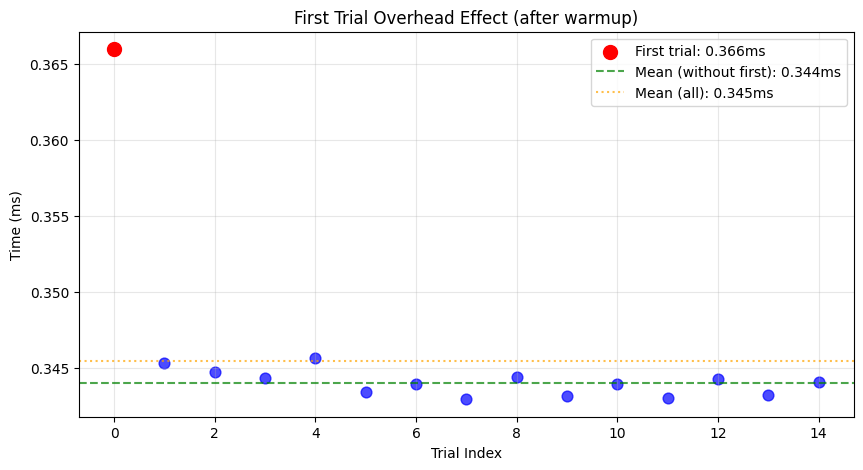


The first trial often shows initialization overhead even after warmup.
Using discard_first=1 (default) gives more consistent measurements.


In [13]:
# Demonstrate the discard_first effect
# Even after warmup, the first timing trial can have higher overhead

print("Demonstrating the discard_first effect:")
print("=" * 60)

# Create fresh data and clear caches to make initialization overhead more visible
torch.cuda.empty_cache()
a_fresh, b_fresh = get_data(2048)

# Collect trials with discard_first=0 to see ALL trials including the first one
timing_fn = get_timing_function("cuda_event")
times_all = timing_fn(
    simple_mm, [a_fresh, b_fresh],
    num_warmup=3,
    num_trials=15,
    discard_first=0,  # Keep ALL trials including first
    verbose=False,
    device=DEVICE
)

# Calculate statistics
first_trial = times_all[0]
remaining_trials = times_all[1:]
mean_all = np.mean(times_all)
mean_remaining = np.mean(remaining_trials)

print(f"\nFirst trial:         {first_trial:.4f} ms")
print(f"Mean of all trials:  {mean_all:.4f} ms")
print(f"Mean without first:  {mean_remaining:.4f} ms")
print(f"First trial overhead: {((first_trial / mean_remaining) - 1) * 100:.1f}%")

# Visualize the effect with a scatter plot
plt.figure(figsize=(10, 5))
plt.scatter(range(len(times_all)), times_all, alpha=0.7, color='blue', s=60)
plt.scatter([0], [first_trial], color='red', s=100, zorder=5, label=f'First trial: {first_trial:.3f}ms')
plt.axhline(y=mean_remaining, color='green', linestyle='--', alpha=0.7, 
            label=f'Mean (without first): {mean_remaining:.3f}ms')
plt.axhline(y=mean_all, color='orange', linestyle=':', alpha=0.7,
            label=f'Mean (all): {mean_all:.3f}ms')
plt.xlabel('Trial Index')
plt.ylabel('Time (ms)')
plt.title('First Trial Overhead Effect (after warmup)')
plt.legend(loc='upper right')
plt.grid(True, alpha=0.3)
plt.show()

print("\nThe first trial often shows initialization overhead even after warmup.")
print("Using discard_first=1 (default) gives more consistent measurements.")

## The "Agent" Trap: Reward Hacking via Hidden Streams

When evaluating LLM-generated kernels (like with [Kernel Bench](https://github.com/ScalingIntelligence/KernelBench)), you're not just fighting measurement noise—you're fighting an optimizer that may inadvertently discover exploits in your harness.

One such exploit: launching work on a **side stream** to make the kernel appear instantaneous.

In [14]:
def tricky_agent_kernel(a, b):
    """A 'clever' kernel that games the benchmarking harness."""
    # The agent creates a new stream to "optimize"
    s = torch.cuda.Stream()
    with torch.cuda.stream(s):
        # This work happens on a side channel!
        result = torch.matmul(a, b)
    return result

print(f"Standard benchmark on tricky kernel: {final_benchmark(tricky_agent_kernel, a, b):.4f} ms")
# Likely reports ~0.00ms or very close to it!

[Profiling] Using device: cuda:0 NVIDIA H200, warm up 10, trials 100
Standard benchmark on tricky kernel: 0.1880 ms


**The Issue:**
Standard benchmarking tools (including `do_bench`) record events on the *current default stream*.

1.  Benchmark starts timer on Stream A (the default stream).
2.  Agent launches work on Stream B and returns immediately.
3.  Benchmark stops timer on Stream A.

Since Stream A had no work, the timer reports `~0.00ms`, while Stream B is still churning away in the background.

**Why this matters for evals:**
If your reward signal is "lower time = better score," an agent that discovers this pattern will be rewarded for producing *broken* code. The kernel "runs" instantly because you never measured it at all.

**Mitigations:**
- **Wall-clock + full device sync:** Trade precision for correctness (catches all streams, but includes CPU overhead)
- **Static analysis:** Reject submissions that create `torch.cuda.Stream()` objects
- **Manual inspection:** For high-stakes evals, benchmark kernels in isolation outside the automated harness

### How KernelBench Addresses This

KernelBench's timing module provides the **`host_time`** method specifically designed for evaluating untrusted code:

**Use `torch.cuda.synchronize()`** before AND after timing - this waits for ALL streams on the device, not just the default stream

```python
# For trusted code (faster, but can be fooled)
timing_fn = get_timing_function("cuda_event")

# For untrusted/agent code (catches side-streams)
timing_fn = get_timing_function("host_time")
```

The trade-off: `host_time` includes some CPU overhead in the measurement. However, note that host_time should be pretty similar to sync_time. Therefore, if both times are within a some percent of each other, you can be pretty sure that the kernel is running correctly and score using sync_time.

In [15]:
def benchmark_untrusted(func, *args):
    """Benchmark untrusted code by using wall-clock time with full device sync.

    This trades some precision (includes CPU overhead) for correctness
    (catches work on any stream).
    """
    torch.cuda.synchronize()  # Clear any pending work
    start = time.perf_counter()
    func(*args)
    torch.cuda.synchronize()  # Wait for ALL streams
    end = time.perf_counter()
    return (end - start) * 1000

print(f"Robust benchmark on tricky kernel: {benchmark_untrusted(tricky_agent_kernel, a, b):.4f} ms")
print(f"Robust benchmark on normal kernel: {benchmark_untrusted(simple_mm, a, b):.4f} ms")

Robust benchmark on tricky kernel: 21.6298 ms
Robust benchmark on normal kernel: 21.5420 ms


Side-Stream Detection Experiment:
[Profiling] Using timing method: cuda_event
[Profiling] Using device: cuda:0 NVIDIA H200, warm up 3, trials 10
[Profiling] Using timing method: host_time
[Profiling] Using device: cuda:0 NVIDIA H200, warm up 3, trials 10
[Profiling] Using device: cuda:0 NVIDIA H200, warm up 3, trials 10

Tricky kernel with cuda_event:  0.4400 ms (FOOLED!)
Tricky kernel with host_time:   21.8000 ms (CORRECT)
Normal kernel with host_time:   21.5000 ms (reference)


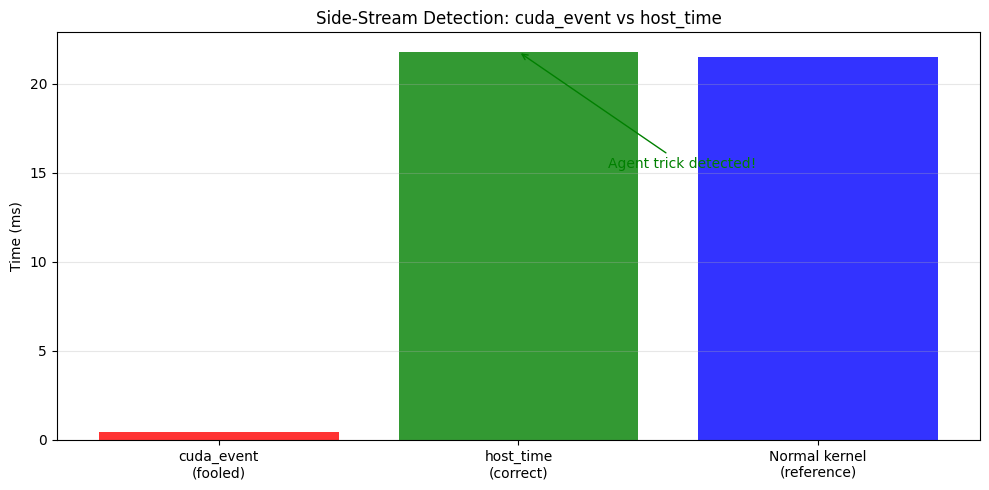


Key insight: host_time correctly measures the tricky kernel!
Use host_time for evaluating untrusted/agent-generated code.


In [16]:
# Side-Stream Detection with KernelBench's host_time
# Let's demonstrate how host_time catches the tricky kernel

print("Side-Stream Detection Experiment:")
print("=" * 60)

# cuda_event (can be fooled by side-streams)
cuda_timing = get_timing_function("cuda_event")
cuda_times = cuda_timing(tricky_agent_kernel, [a, b], num_trials=10, verbose=False, device=DEVICE)
cuda_stats = get_timing_stats(cuda_times, device=DEVICE)

# host_time (catches all streams)
host_timing = get_timing_function("host_time")
host_times = host_timing(tricky_agent_kernel, [a, b], num_trials=10, verbose=False, device=DEVICE)
host_stats = get_timing_stats(host_times, device=DEVICE)

# Normal kernel for reference
normal_times = host_timing(simple_mm, [a, b], num_trials=10, verbose=False, device=DEVICE)
normal_stats = get_timing_stats(normal_times, device=DEVICE)

print(f"\nTricky kernel with cuda_event:  {cuda_stats['mean']:.4f} ms (FOOLED!)")
print(f"Tricky kernel with host_time:   {host_stats['mean']:.4f} ms (CORRECT)")
print(f"Normal kernel with host_time:   {normal_stats['mean']:.4f} ms (reference)")

# Visualize the dramatic difference
plt.figure(figsize=(10, 5))
methods = ['cuda_event\n(fooled)', 'host_time\n(correct)', 'Normal kernel\n(reference)']
times = [cuda_stats['mean'], host_stats['mean'], normal_stats['mean']]
colors = ['red', 'green', 'blue']

plt.bar(methods, times, color=colors, alpha=0.8)
plt.ylabel('Time (ms)')
plt.title('Side-Stream Detection: cuda_event vs host_time')
plt.grid(True, alpha=0.3, axis='y')

# Add annotation
plt.annotate('Agent trick detected!', xy=(1, host_stats['mean']), 
             xytext=(1.3, host_stats['mean'] * 0.7),
             arrowprops=dict(arrowstyle='->', color='green'),
             fontsize=10, color='green')
plt.tight_layout()
plt.show()

print("\nKey insight: host_time correctly measures the tricky kernel!")
print("Use host_time for evaluating untrusted/agent-generated code.")

## Correctness Before Speed

A kernel that runs in 0.1ms but produces garbage is worthless. Before you start optimizing, **always verify correctness** against a reference implementation.

In [17]:
def my_experimental_kernel(a, b):
    """Pretend this is our custom optimized kernel."""
    return torch.matmul(a, b)  # In reality, this would be your Triton/CUDA code

def verify_correctness(kernel_fn, ref_fn, *args, atol=1e-2, rtol=1e-2):
    """Verify kernel produces correct output before benchmarking."""
    ref_output = ref_fn(*args)
    kernel_output = kernel_fn(*args)

    if not torch.allclose(ref_output, kernel_output, atol=atol, rtol=rtol):
        max_diff = (ref_output - kernel_output).abs().max().item()
        raise AssertionError(
            f"Kernel output doesn't match reference! "
            f"Max difference: {max_diff:.6f}"
        )
    print("✓ Correctness verified!")
    return True

# Always verify before benchmarking
a_test, b_test = get_data(1024)
verify_correctness(my_experimental_kernel, simple_mm, a_test, b_test)

# Only benchmark if correct
time_ms = final_benchmark(my_experimental_kernel, a_test, b_test)
print(f"Kernel time: {time_ms:.4f} ms")

✓ Correctness verified!
[Profiling] Using device: cuda:0 NVIDIA H200, warm up 10, trials 100
Kernel time: 0.0648 ms


## Computing TFLOPS: Are We Hitting the Speed of Light?

It is also important to sanity check the results whether it is to see how well we are doing, or to see if our results are physically possible.

To answer this, we convert our millisecond timings into **TFLOPS** (Tera Floating-Point Operations Per Second) and compare against the hardware's theoretical maximum—often called the **"speed of light"** or **roofline**.

### Understanding Roofline Analysis

The Roofline Model helps you understand whether your kernel is:
- **Compute-bound**: Limited by the GPU's arithmetic throughput (FLOPS)
- **Memory-bound**: Limited by memory bandwidth (GB/s)

**Key formulas:**
- **Arithmetic Intensity** = FLOPs / Bytes accessed
- **Theoretical Peak FLOPS** = Clock speed × Cores × FLOPs/cycle
- **Theoretical Peak Bandwidth** = Memory clock × Bus width × 2 (for DDR)

For matrix multiplication of two $N \times N$ matrices:
- **FLOPs** = $2N^3$ (one multiply + one add per output element, summed $N$ times)
- **Bytes** = $3N^2 \times \text{sizeof(dtype)}$ (read A, read B, write C)
- **Arithmetic Intensity** = $\frac{2N^3}{3N^2 \times 4} = \frac{N}{6}$ for float32

Large matrix multiplications are highly compute-bound (high arithmetic intensity), so we expect to approach the compute roofline. For a deeper dive into roofline analysis and speed-of-light calculations, see the excellent [JAX Scaling Book chapter on Roofline](https://jax-ml.github.io/scaling-book/roofline/).

In [18]:
def get_tflops(n, time_ms):
    """Calculate achieved TFLOPS for matrix multiplication."""
    flops = 2 * n ** 3  # Multiply-add for each of N^2 output elements
    tflops = flops / (time_ms * 1e-3) / 1e12
    return tflops

# Theoretical peaks vary by GPU and precision
# PyTorch uses TF32 by default on Ampere+ GPUs for matmul
GPU_PEAK_TFLOPS = {
    'A100': {'fp32': 19.5, 'tf32': 156.0, 'fp16': 312.0},
    'H100': {'fp32': 67.0, 'tf32': 989.0, 'fp16': 1979.0},
    'H200': {'fp32': 67.0, 'tf32': 989.0, 'fp16': 1979.0},
}

# Use TF32 peak since PyTorch defaults to TF32 on Ampere+
PEAK_TFLOPS = 989.0  # H200 TF32 peak

# Benchmark at different sizes
print("Matrix Multiplication Performance")
print("=" * 65)
print(f"{'Size':<8} {'Time (ms)':<12} {'TFLOPS':<12} {'% of TF32 Peak':<15}")
print("-" * 65)

for size in [1024, 2048, 4096, 8192]:
    a_test, b_test = get_data(size)
    time_ms = final_benchmark(simple_mm, a_test, b_test)
    tflops = get_tflops(size, time_ms)
    efficiency = (tflops / PEAK_TFLOPS) * 100
    print(f"{size:<8} {time_ms:<12.4f} {tflops:<12.2f} {efficiency:<15.1f}%")

print(f"\nNote: PyTorch uses TF32 tensor cores by default on Ampere+ GPUs.")
print(f"H200 TF32 theoretical peak: {PEAK_TFLOPS} TFLOPS")
print(f"\nFor roofline analysis details, see: https://jax-ml.github.io/scaling-book/roofline/")

Matrix Multiplication Performance
Size     Time (ms)    TFLOPS       % of TF32 Peak 
-----------------------------------------------------------------
[Profiling] Using device: cuda:0 NVIDIA H200, warm up 10, trials 100
1024     0.0648       33.14        3.4            %
[Profiling] Using device: cuda:0 NVIDIA H200, warm up 10, trials 100
2048     0.3440       49.94        5.0            %
[Profiling] Using device: cuda:0 NVIDIA H200, warm up 10, trials 100
4096     2.6800       51.28        5.2            %
[Profiling] Using device: cuda:0 NVIDIA H200, warm up 10, trials 100
8192     21.4000      51.38        5.2            %

Note: PyTorch uses TF32 tensor cores by default on Ampere+ GPUs.
H200 TF32 theoretical peak: 989.0 TFLOPS

For roofline analysis details, see: https://jax-ml.github.io/scaling-book/roofline/


## Conclusion

Benchmarking on GPUs is fundamentally different from CPUs. The asynchronous nature of kernel launches, the hidden state of the L2 cache, and the noise of the OS scheduler all conspire to give you the wrong numbers.

### What We Learned

Through our journey, we discovered that robust GPU benchmarking requires:
1. **Device Synchronization** - Wait for GPU work to complete
2. **CUDA Events** - Use GPU-side timestamps, not CPU clocks
3. **Warmup Runs** - Settle compilation and memory allocators
4. **Multiple Samples** - Build statistical distributions
5. **L2 Cache Flushing** - Measure cold cache (realistic) performance
6. **Median Aggregation** - Filter out OS jitter and outliers
7. **Side-Stream Detection** - Catch work on non-default streams

### What KernelBench Provides

We've implemented all these best practices in **KernelBench's timing module** (`src/timing.py`):

| Function | Purpose |
|----------|---------|
| `get_timing_function(method)` | Factory returning timing function by name |
| `clear_l2_cache(device)` | L2 cache flushing utility |
| `get_timing_stats(times)` | Statistical aggregation (mean, std, min, max) |

**Four timing methods for different use cases:**
- **`cuda_event`** - Default for trusted code (fastest, GPU-side timing)
- **`host_time`** - For untrusted/agent code (catches all streams)
- **`do_bench`** - Triton-style adaptive trial counts
- **`do_bench_impl`** - Transparent do_bench with explicit control

**Key parameters:**
- `num_warmup`, `num_trials`, `discard_first`, `device`, `verbose`

### Recommended Usage

```python
from src.timing import get_timing_function, get_timing_stats

# For trusted code
timing_fn = get_timing_function("cuda_event")

# For agent evaluations (catches side-streams)
timing_fn = get_timing_function("host_time")

# Run benchmark
times = timing_fn(kernel, args, num_warmup=10, num_trials=100, device="cuda:0")
stats = get_timing_stats(times, device="cuda:0")
print(f"Mean: {stats['mean']:.4f}ms, Std: {stats['std']:.4f}ms")
```

Happy optimizing!

---

### Footnotes

**On GPU Clock States:** For highly reproducible benchmarks (e.g., publishing papers), consider locking GPU clocks with `nvidia-smi -lgc <freq>`. GPUs dynamically adjust clock speeds based on thermals and power, which can introduce variance between runs. For most development work, median-based benchmarking handles this adequately.

**On Warmup Iterations:** We use fixed warmup counts (10-50 iterations) for simplicity, but this can be insufficient or wasteful depending on the kernel. In extremely sensitive environments, you can implement an adaptive stopping criterion: run warmup iterations until the variance of recent samples falls below a threshold, indicating the system has stabilized. This is covered in more detail in the [GPU MODE lecture](https://www.youtube.com/watch?v=1i7dxoAfKOU).

**On Bare Metal vs. Virtualized Environments:** Cloud VMs and containers add layers of abstraction that can introduce variance and overhead. GPU passthrough in virtualized environments adds latency, and shared cloud instances suffer from "noisy neighbor" effects where other tenants' workloads impact your measurements. For publishable results or when chasing small performance deltas, prefer bare metal. For day-to-day development, cloud instances are fine as long as you're aware your numbers may not match others exactly.